EPSFBuilder (12 maxiters):   0%|          | 0/12 [00:00<?, ?it/s]

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

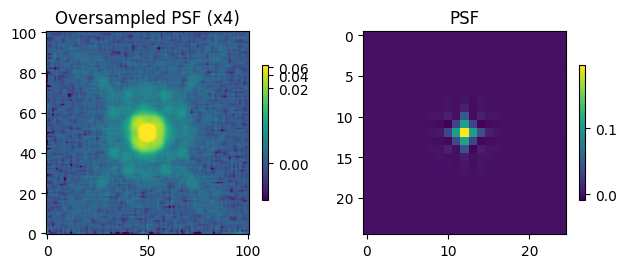

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import emcee 
import pyimfit 
from astropy.io import fits
import corner

from IPython.display import Latex
import sys
import warnings
from matplotlib.ticker import LogFormatter

from photutils.datasets import (load_simulated_hst_star_image,
                                make_noise_image)

from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder
from photutils import profiles
from astropy.table import Table

hdu = load_simulated_hst_star_image()
data = hdu.data
data += make_noise_image(data.shape, distribution='gaussian', mean=10.0,
                         stddev=5.0, seed=123)

peaks_tbl = find_peaks(data, threshold=500.0)

size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']
y = peaks_tbl['y_peak']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize))
        & (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

stars_tbl = Table()
stars_tbl['x'] = x[mask]
stars_tbl['y'] = y[mask]

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.0)
data -= median_val

nddata = NDData(data=data)
stars = extract_stars(nddata, stars_tbl, size=25)


epsf_builder = EPSFBuilder(oversampling=4, maxiters=12)  
epsf, fitted_stars = epsf_builder(stars) 
epsf_builder1 = EPSFBuilder(oversampling=1,shape=(25,25))  
epsf1, fitted_stars1 = epsf_builder1(stars) 

fig,ax = plt.subplots(1,2)
norm = simple_norm(epsf.data, 'log', percent=99.0)
im0 = ax[0].imshow(epsf.data,norm=norm, origin='lower', cmap='viridis')
im1= ax[1].imshow(epsf1.data)
[fig.colorbar([im0,im1][i], ax=[ax[0],ax[1]][i],shrink=0.3) for i in range(2)]
[ax[i].set_title(['Oversampled PSF (x4)', "PSF"][i]) for i in range(2)]
fig.tight_layout();

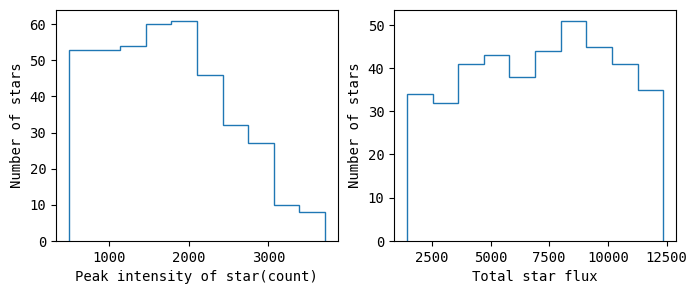

In [67]:
df = pd.DataFrame([[stars[i].origin, np.max(stars[i].data), stars[i].flux] for i in range(len(stars))],columns=['pos',"maxI","flux"])
fig,ax = plt.subplots(1,2,figsize=(8,3))
[ax[i].hist([df.maxI,df.flux][i],histtype="step") for i in range(2)]
[ax[i].set_xlabel(['Peak intensity of star(count)','Total star flux'][i]) for i in range(2)]
[ax[i].set_ylabel('Number of stars') for i in range(2)];

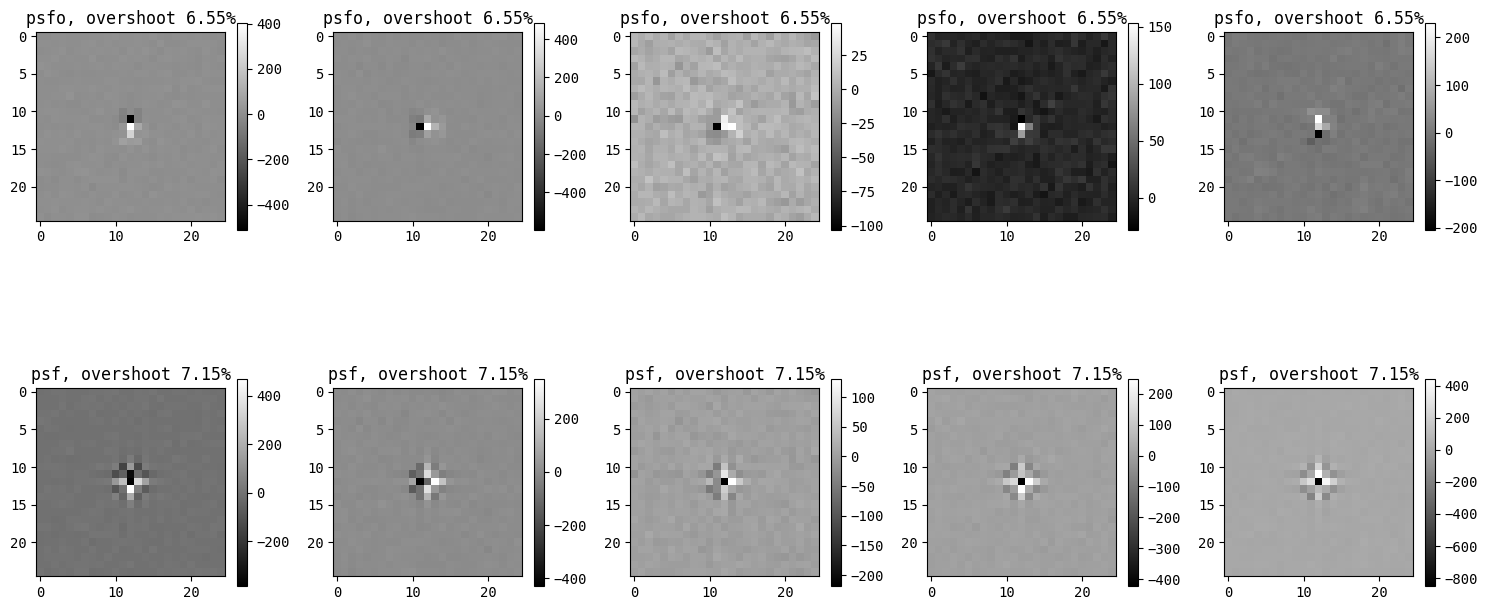

In [78]:
# make scaled psf with same size as star
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['image.cmap'] = 'gray'
fig, ax = plt.subplots(2,5,figsize=(15,8),squeeze=True)
ax = ax.ravel()
for n in range(len(stars[:5])):
    resi = -stars[n].compute_residual_image(epsf)
    err = np.sum(resi)/stars[n].estimate_flux()*100
    im = ax[n].imshow(resi)
    fig.colorbar(im,ax=ax[n],shrink=0.5)
    ax[n].set_title(f"psfo, overshoot {abs(err):.2f}%")
   
    resi1 = -stars[n].compute_residual_image(epsf1)
    err1 = np.sum(resi1)/stars[n].estimate_flux()*100
    i = int(n+5)
    im1 = ax[i].imshow(resi1)
    fig.colorbar(im1,ax=ax[i],shrink=0.5)
    ax[i].set_title(f"psf, overshoot {abs(err1):.2f}%")

fig.tight_layout();

Integrated PSF profile: 8.38
Integrated average stars profile: 7.96


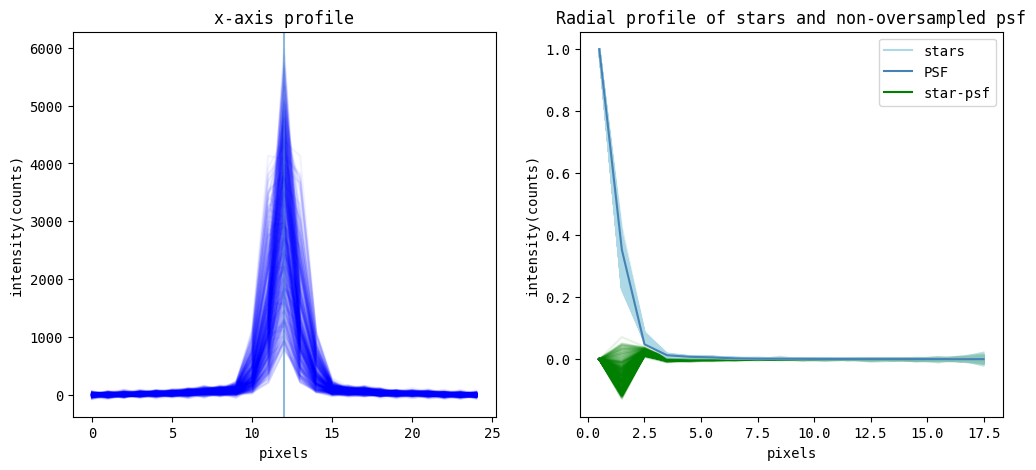

In [77]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

for n in range(len(stars)):
    ax[0].plot(np.sum(stars[n].data, axis=0), "b", alpha=0.05)

ax[0].axvline(x=stars[0].cutout_center[0],alpha=0.5)
ax[0].set_title("x-axis profile")
ax[0].set_xlabel("pixels")
ax[0].set_ylabel("intensity(counts)")

rp_psf1 = profiles.RadialProfile(epsf1.data,xycen=stars[i].cutout_center,radii = np.arange(25))
rp_psf1.normalize("max")

for i in range(len(stars)):
    rp_star = profiles.RadialProfile(stars[i].data,xycen=stars[i].cutout_center,radii=np.arange(25))
    rp_star.normalize("max")
    ax[1].plot(rp_star.radius, rp_star.profile, color="lightblue", alpha=0.5)
    ax[1].plot(rp_star.radius, rp_star.profile-rp_psf1.profile, "g", alpha=0.1)

# profile of psf   
ax[1].plot(rp_psf1.radius, rp_psf1.profile,"steelblue")
ax[1].set_title("Radial profile of stars and non-oversampled psf")
ax[1].set_xlabel("pixels")
ax[1].set_ylabel("intensity(counts)")

legend_handles = [plt.Line2D([], [], color='lightblue', label='stars'),
                  plt.Line2D([], [], color='steelblue', label='PSF'),
                  plt.Line2D([], [], color='green', label='star-psf')]

ax[1].legend(handles=legend_handles)

psfsum = rp_psf1.area*rp_psf1.profile
print(f"Integrated PSF profile: {np.sum(psfsum[~np.isnan(psfsum)]):.2f}")
s = 0
for i in range(len(stars)):
    rp_star = profiles.RadialProfile(stars[i].data,xycen=stars[0].cutout_center,radii=np.arange(70))
    rp_star.normalize("max")
    m = rp_star.area*rp_star.profile
    s+=np.sum(m[~np.isnan(m)])
print(f"Integrated average stars profile: {s/len(stars):.2f}")

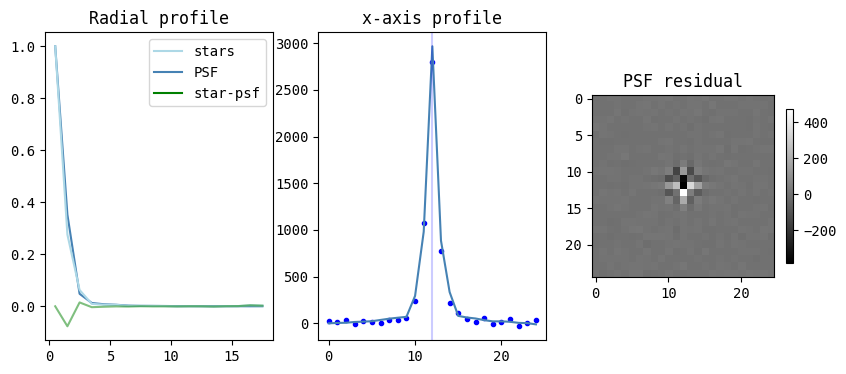

<Figure size 640x480 with 0 Axes>

In [80]:
starnum=0
psf1rp = profiles.RadialProfile(epsf1.data,xycen=stars[starnum].cutout_center,radii = np.arange(20))
starnrp = profiles.RadialProfile(stars[starnum].data,xycen=stars[starnum].cutout_center,radii = np.arange(20))
psf1rp.normalize("max")
starnrp.normalize("max")
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].plot(psf1rp.radius, psf1rp.profile,"steelblue")
ax[0].plot(starnrp.radius, starnrp.profile,"lightblue")
ax[0].plot(starnrp.radius, starnrp.profile-psf1rp.profile,"g", alpha=0.5)

ax[1].plot(np.sum(stars[starnum].data, axis=0), "bo",markersize=3)
shp = stars[starnum].shape[0]
cen = stars[starnum].cutout_center[0]
x,y =np.meshgrid(np.arange(shp), np.arange(shp))
psf = epsf1.evaluate(x=x,y=y,x_0=cen,y_0=cen,flux = stars[starnum].estimate_flux())
ax[1].plot(np.sum(psf, axis=0), "steelblue")
ax[1].axvline(x=stars[starnum].cutout_center[0],c="b", alpha=0.2)

im2 = ax[2].imshow(-stars[starnum].compute_residual_image(epsf1))
fig.colorbar(im2, ax=ax[2], shrink=0.5)

fig = plt.figure()
legend_handles = [plt.Line2D([], [], color='lightblue', label='stars'),
                  plt.Line2D([], [], color='steelblue', label='PSF'),
                  plt.Line2D([], [], color='green', label='star-psf')]

[ax[i].set_title(['Radial profile','x-axis profile','PSF residual'][i]) for i in range(3)]

ax[0].legend(handles=legend_handles)